In [1]:

try:
  import yahoo_fin.stock_info as si
except ModuleNotFoundError:
  if 'google.colab' in str(get_ipython()):
    %pip install yahoo_fin

  import yahoo_fin.stock_info as si

In [2]:

# importing necessary packages and libraries
import os
import time
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense , LSTM, Dropout,Bidirectional
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

In [3]:
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [4]:

# shuffling the data so that model has varying train, test and validation sets
def shuffle(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    if isinstance(ticker, str):
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    result = {}

    result['df'] = df.copy()

    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."

    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}

        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        result["column_scaler"] = column_scaler

    df['future'] = df['adjclose'].shift(-lookup_step)

    last_sequence = np.array(df[feature_columns].tail(lookup_step))

    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)

    result['last_sequence'] = last_sequence

    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)

    X = np.array(X)
    y = np.array(y)
    if split_by_date:

        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:

            shuffle(result["X_train"], result["y_train"])
            shuffle(result["X_test"], result["y_test"])
    else:

        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y,
                                                                                test_size=test_size, shuffle=shuffle)

    dates = result["X_test"][:, -1, -1]

    result["test_df"] = result["df"].loc[dates]

    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]

    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result

In [8]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_squared_error", optimizer="adam", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_squared_error"], optimizer=optimizer)
    return model

In [9]:

N_STEPS = 50
LOOKUP_STEP = 1 # Next day - how many steps(days) ahead: here it is 1 day
# scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"
# shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
# split the training/testing set by date or not
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
# test ratio size: 0.2
TEST_SIZE = 0.2

# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")

### model parameters
N_LAYERS = 2
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
DROPOUT = 0.5
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
# training parameters
# mean absolute error loss
LOSS = "mean_squared_error"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 5
# Apple stock market
ticker = "NVDA"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [10]:
# loading the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE,
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS)
# save the dataframe
data["df"].to_csv(ticker_data_filename)
# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

# Training the model on Apple stock data
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/20
77/77 [==============================] - ETA: 0s - loss: 9.1223e-04 - mean_squared_error: 9.1223e-04
Epoch 1: val_loss improved from inf to 0.00019, saving model to results\2023-09-05_NVDA-sh-1-sc-1-sbd-0-mean_squared_error-adam-LSTM-seq-50-step-1-layers-2-units-256.h5
77/77 [==============================] - 58s 655ms/step - loss: 9.1223e-04 - mean_squared_error: 9.1223e-04 - val_loss: 1.9230e-04 - val_mean_squared_error: 1.9230e-04
Epoch 2/20
77/77 [==============================] - ETA: 0s - loss: 3.7074e-04 - mean_squared_error: 3.7074e-04
Epoch 2: val_loss did not improve from 0.00019
77/77 [==============================] - 49s 631ms/step - loss: 3.7074e-04 - mean_squared_error: 3.7074e-04 - val_loss: 1.9782e-04 - val_mean_squared_error: 1.9782e-04
Epoch 3/20
77/77 [==============================] - ETA: 0s - loss: 3.2293e-04 - mean_squared_error: 3.2293e-04
Epoch 3: val_loss improved from 0.00019 to 0.00017, saving model to results\2023-09-05_NVDA-sh-1-sc-1-sbd-0-mean

In [11]:
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")


In [12]:

%load_ext tensorboard
%tensorboard --logdir="logs"

In [13]:

# Storing all results
def get_final_df(model, data):

    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0

    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]

    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]

    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred

    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test

    test_df.sort_index(inplace=True)
    final_df = test_df

    final_df["buy_profit"] = list(map(buy_profit,
                                    final_df["adjclose"],
                                    final_df[f"adjclose_{LOOKUP_STEP}"],
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])

                                    )

    final_df["sell_profit"] = list(map(sell_profit,
                                    final_df["adjclose"],
                                    final_df[f"adjclose_{LOOKUP_STEP}"],
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])

                                    )
    return final_df

In [14]:
# function to predict values
def predict(model, data):

    last_sequence = data["last_sequence"][-N_STEPS:]

    last_sequence = np.expand_dims(last_sequence, axis=0)

    prediction = model.predict(last_sequence)

    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [15]:


# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)
     

In [16]:
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [17]:

final_df = get_final_df(model, data)

39/39 [==============================] - 9s 179ms/step


In [18]:
future_price = predict(model, data)

1/1 [==============================] - 0s 85ms/step


In [19]:

# accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [20]:

# printing metrics
print(f"Future price after {LOOKUP_STEP} days is ${future_price:.2f}")
print(f"{LOSS} loss:", loss)
print("Accuracy score:", accuracy_score*100)

Future price after 1 days is $492.50
mean_squared_error loss: 9.190457785734907e-05
Accuracy score: 50.36615134255492


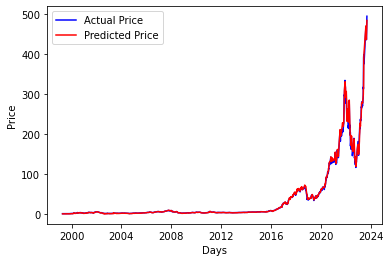

In [21]:

# plot true/pred prices graph
import matplotlib.pyplot as plt

def plot_graph(test_df):

    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()
plot_graph(final_df)